# Importing libraries and datasets

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csr_matrix, save_npz
from sklearn import neighbors
from sklearn.cluster import KMeans

In [3]:
# import datasets:
genome_scores =  pd.read_csv('../ml-20m/genome-scores.csv')
movies = pd.read_csv('../ml-20m/movies.csv',  usecols = ["movieId"])
ratings = pd.read_csv('../ml-20m/ratings.csv', usecols = ["movieId", "userId", "rating"])

# Preprocessing

In [2]:
# Count movies in the movies df
tmm = movies["movieId"].nunique()
# Count movies in the matings df
tmr = ratings["movieId"].nunique()
# Count movies in the genome_score df
tmg = genome_scores["movieId"].nunique()
print("The total number of movies in movies, ratings and genome score dataframes, respectively :", tmm, tmr, tmg)

The total number of movies in movies, ratings and genome score dataframes, respectively : 27278 26744 10381


In [4]:
# Create a movie - user - rating data frame with movies present in all the dataframes
tagged_movies = pd.DataFrame(genome_scores['movieId'].value_counts()).index
mov_rat = pd.merge(movies, ratings, on="movieId")

In [5]:
final_df = mov_rat[mov_rat["movieId"].isin(tagged_movies)]

In [7]:
#Reducing the dataframe by removing unpopular movies and anactive 
#Shringking movies
gf = pd.DataFrame(final_df['movieId'].value_counts())
rare_movies = gf[gf['movieId'] <= 1000].index
final_df = final_df[~final_df["movieId"].isin(rare_movies)]
print('Out of total of ', gf.shape[0] , ' movies, ', rare_movies.shape[0], ' are considered rare and will be removed.')
print('The final number of movies is ', final_df["movieId"].nunique())

#Shringking users
udf = pd.DataFrame(final_df['userId'].value_counts())
lazy_users = udf[udf['userId'] <= 500].index
final_df = final_df[~final_df["userId"].isin(lazy_users)]
print('Out of total of ', udf.shape[0] , ' users, ', lazy_users.shape[0], ' are considered lazy and will be removed.')
print('The final number of users is ', final_df["userId"].nunique())

# Create the user->movie sparse rating matrix. Fill the NA with zeros
pivot = final_df.pivot_table(index="userId", columns="movieId", values="rating")
pivot.fillna(0,inplace=True)

#Estimate sparsity
sparsity = 1.0 - ( np.count_nonzero(pivot) / float(pivot.size) )
print("The resulting sparcity of the matrix is:", sparsity)

#Create non-sparce dataset
csr_data = csr_matrix(pivot.values)

Out of total of  10370  movies,  7214  are considered rare and will be removed.
The final number of movies is  3156
Out of total of  138493  users,  132651  are considered lazy and will be removed.
The final number of users is  5842
The resulting sparcity of the matrix is: 0.7548389812159577


In [8]:
final_df.to_csv('user_movie_rating.csv', index=False) 

In [12]:
pivot.to_csv('pivot.csv', index=True, header="userId")  

In [10]:
save_npz("sparse_ratings.npz", csr_data)

# Modelling
Below we execute the following steps:
* Randomly choosing a target user fo whom recommendations will be generated
* Pre-clustering of users using KMeans model
* Creating a new matrix corresponding with users in the target user cluster
* Defining the Mean User Vector for the working data matrix
* Training the Nearest Neighbors model on the Mean User Vector
* Processing the results of the NN modeling: collecting, aggregating, filtering results and presenting recommendations

## Pre-clustering with KMeans

In [14]:
# Pre-clustering users with K-means
# 20 clusters
kmeans = KMeans(n_clusters=20, algorithm='lloyd', n_init='auto').fit(csr_data) # Demands lots of resources
labels = kmeans.labels_ 
unique, counts = np.unique(labels, return_counts=True)

print("The number of users per class:\n")
for u, c in zip(unique, counts):
    print(u, c)

The number of users per class:

0 460
1 345
2 457
3 532
4 300
5 270
6 605
7 702
8 390
9 327
10 314
11 353
12 145
13 381
14 184
15 442
16 211
17 149
18 499
19 375


In [21]:
#Load sparce crr user-movie utility matrix
print(csr_data)

  (0, 0)	4.0
  (0, 1)	3.0
  (0, 4)	3.0
  (0, 5)	3.0
  (0, 9)	4.0
  (0, 10)	5.0
  (0, 15)	2.0
  (0, 16)	2.0
  (0, 17)	3.0
  (0, 19)	3.0
  (0, 20)	2.0
  (0, 21)	3.0
  (0, 24)	2.0
  (0, 31)	5.0
  (0, 32)	2.0
  (0, 34)	5.0
  (0, 35)	2.0
  (0, 42)	4.0
  (0, 44)	4.0
  (0, 45)	4.0
  (0, 57)	4.0
  (0, 70)	4.0
  (0, 74)	2.0
  (0, 83)	5.0
  (0, 84)	3.0
  :	:
  (5841, 1999)	4.0
  (5841, 2010)	5.0
  (5841, 2043)	5.0
  (5841, 2061)	5.0
  (5841, 2066)	5.0
  (5841, 2074)	3.0
  (5841, 2076)	4.0
  (5841, 2078)	2.0
  (5841, 2086)	4.0
  (5841, 2087)	4.0
  (5841, 2097)	4.0
  (5841, 2104)	4.0
  (5841, 2112)	5.0
  (5841, 2134)	5.0
  (5841, 2153)	4.0
  (5841, 2156)	4.0
  (5841, 2192)	5.0
  (5841, 2196)	5.0
  (5841, 2206)	5.0
  (5841, 2217)	5.0
  (5841, 2279)	3.0
  (5841, 2282)	4.0
  (5841, 2287)	1.0
  (5841, 2296)	4.0
  (5841, 2298)	4.0


In [15]:
# Let's randomly choose an existing user
user_index = np.random.choice(csr_data.shape[0])    
print('The target user ', user_index, ' belongs to the cluster number', labels[user_index])

# Creating the csr matrix only for usrs of the cluster of the target user
# get indices of the users in the selected cluster
cluster_user_indices = []
for i,l in enumerate(labels):
    if l == labels[user_index]:
        cluster_user_indices.append(i)
        
# create a new csr_data only with the users from the cluster
mask = np.zeros(csr_data.shape[0], dtype=bool)
mask[cluster_user_indices] = True

#csr_data_cluster = csr_data[mask]
csr_data_cluster = csr_data 

# When shrinking the matrix, the index of the target user changes to the new_user_index
new_user_index = np.nonzero(np.array(cluster_user_indices) == user_index)[0][0]
print('The new index of the target user is ', new_user_index)

# Calculating the mean users' ratings
#def calculate_mean_user_vector(csr_data):
#    csr_mean = csr_data.sum(axis=1)/csr_data.getnnz(axis=1)
#    mean_user_vector = np.asarray(csr_mean)
#    flattened_reshaped = mean_user_vector.mean(axis=1).flatten().reshape(-1, 1)
#    return mean_user_vector.reshape(-1), flattened_reshaped

#mean_user_vector, model_mean_user_vector = calculate_mean_user_vector(csr_data_cluster)

The target user  3272  belongs to the cluster number 2
The new index of the target user is  192


## Nearest Neighbors model

In [16]:
# Create NN object and fit it with the mean user vector

number_of_closest_users = 150
nn = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=number_of_closest_users)
nn.fit(csr_data_cluster) 
number_of_most_closest_users = 20 # for visualization purpose only
nn_sub = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=number_of_most_closest_users)
nn_sub.fit(csr_data_cluster)

# Find the nearest neighbors for the target user (e.g., User1)

mask = np.zeros(csr_data_cluster.shape[0], dtype=bool)
mask[new_user_index] = True
target_user_row = csr_data_cluster[mask]

distances, indices = nn.kneighbors(target_user_row)
distances_sub, indices_sub = nn_sub.kneighbors(target_user_row)

In [58]:
# Exercise: visualize the results as graph
import networkx as nx

G = nx.Graph()
G.add_node(new_user_index)

closest_users = indices.reshape(-1)
closest_users_sub = indices.reshape(-1)[1:number_of_most_closest_users +1]
closest_users_remaining = indices.reshape(-1)[number_of_most_closest_users+1 :]

In [59]:
print(len(closest_users), closest_users)
print(len(closest_users_sub), closest_users_sub)

150 [ 136 5042 2987 4484 7094 1383 1247 1681 4454 4896  844 5856 5142  412
 4071 2222 5582 4303 1560 4480 3510 2796 4134 4715 6166 5161 3641 6824
 1258 2057 5889 2710 4353 1532 2966 7398  444 1794 5617 3758 1371 1836
  886 4262  688  346 6818   59  214 3639  758 5234 1038 6433 5970 2794
 6113 4091 1410 4972 5334 4485 6061 5374 3715 2595 4184 6974 1130 7352
 5818 2176 5104  125 2382 1607 7284 4057 4364   71  740 7066 7304 2682
 4314 6408  963  722 6429 3750  884  958   85  630 2854 4999   44 2275
 2487 3259 4379 1868 1528 4213 7249 2986 2570 7167 3621 1428 6646 1329
 5949 5108 1393  968 6728 1774  656 6537 2907 5373 6766 1780 2741 1469
 1788 4056 4994 3297  955  743 6543 2148 6420 1870  239 4253 2075 4766
 2827 4545 3631 2625 2817   22 7231 4380 4278 3417]
20 [5042 2987 4484 7094 1383 1247 1681 4454 4896  844 5856 5142  412 4071
 2222 5582 4303 1560 4480 3510]


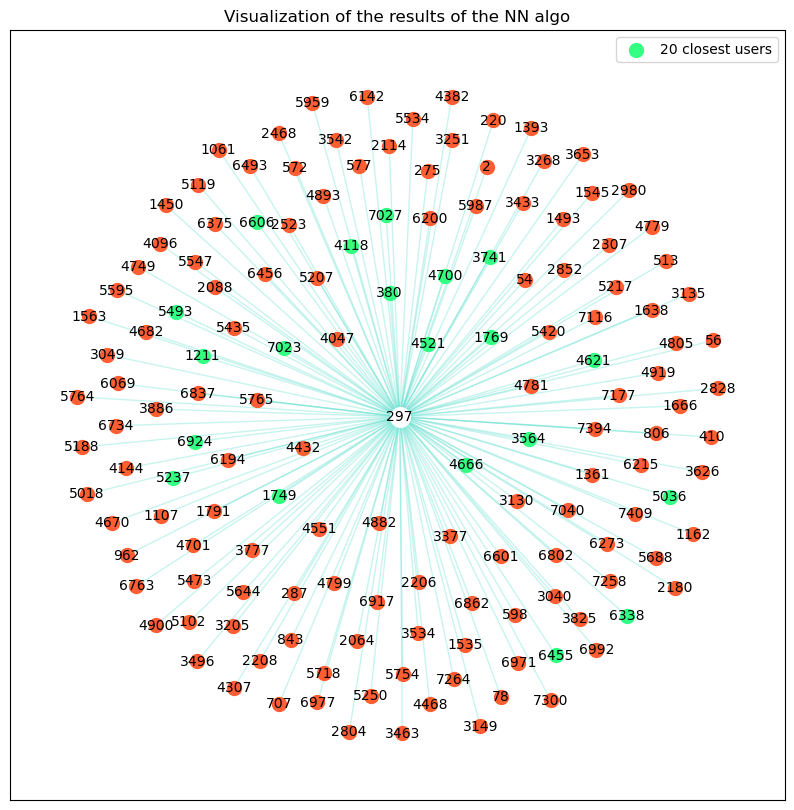

In [37]:
G.add_nodes_from(indices.reshape(-1)[1:])

weights = 1/(distances.reshape(-1)[1:])

G.add_weighted_edges_from(list((new_user_index, n, w) for n,w in zip(closest_users[1:],weights)))

pos = nx.fruchterman_reingold_layout(G)

plt.figure(figsize = (10, 10))
ax = plt.axes()
ax.set_facecolor("white")
plt.title("Visualization of the results of the NN algo")

nx.draw_networkx_nodes(G, pos, node_size = 100, nodelist = closest_users_remaining, node_color = "#ff5e33")
nx.draw_networkx_nodes(G, pos, node_size = 100, nodelist = closest_users_sub, node_color = "#33ff83", label= str(number_of_most_closest_users) + " closest users")
nx.draw_networkx_nodes(G, pos, node_size = 200, nodelist = [new_user_index], node_color = "#ffffff")
nxlabels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edges(G, pos, alpha = 0.3, edge_color = "#48dbc8")
#nx.draw_networkx_edge_labels(G,pos,edge_labels=nxlabels)
#nx.draw_networkx_labels(G,pos,font_size=10, labels={user_index: user_index})
nx.draw_networkx_labels(G,pos,font_size=10)
plt.grid(visible=False)
plt.legend()
plt.show()

## Postprocessing

In [19]:
# Collecting ratings from the closers users
def keep_rows_csr(mat, indices):
    """
   Keep the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    #if not isinstance(mat, scipy.sparse.csr_matrix):
     #   raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = indices.flatten()
    mask = np.zeros(mat.shape[0], dtype=bool)
    mask[indices] = True
    return mat[mask]
    

# a csr matrix with the closest users only
csr_data_closests_users = keep_rows_csr(csr_data_cluster, indices)

# Aggregating the ratings from the closest users
# calculate the averaged rating of the movies given by the neiboghrs

def closest_users_average_ratings(mat):
    mat_array = mat.toarray()
    mat_array[mat_array == 0] = np.nan
    av_ratings = np.nanmean(mat_array, axis=0)
    df = pd.DataFrame(data ={'movieId': , 'rating': av_ratings })
    
    return df


rating_aggregation = closest_users_average_ratings(csr_data_closests_users)

# rank them by sorting
movies_indices_sorted_desc = np.argsort(rating_aggregation)[::-1]
best_20_movies = movies_indices_sorted_desc[:20]

# Filtering:
# get the user movies row
mask = np.zeros(csr_data_cluster.shape[0], dtype=bool)
mask[new_user_index] = True
target_user_row = csr_data_cluster[mask].toarray().flatten()

# get indices of the unwatched movies
unwatched_indices = np.nonzero(target_user_row == 0)

# get indices of the watched movies
watched_indices = np.nonzero(target_user_row != 0)

# keep only unwatches movie indices
filter_arr = []
for element in movies_indices_sorted_desc:
  if element in unwatched_indices[0]:
    filter_arr.append(True)
  else:
    filter_arr.append(False)

movies_to_watch_unfiltered = movies_indices_sorted_desc
movies_to_watch = movies_indices_sorted_desc[filter_arr]

# Provide personalised recommendations
watched_indices = np.nonzero(target_user_row != 0)

# get intersection between watched_indices and recommender indices
intersection_indices = np.intersect1d(watched_indices[0],best_20_movies[0])

print('User watched ', len(watched_indices[0]), ' movies')
print('System recommends ', len(best_20_movies), ' movies')
print(len(intersection_indices), ' movies are in common')

def get_movie_titles_by_indices(indices):
    titles = []
    for i in indices:
        titles.append(pivot.columns[i])
    return titles

print("User " + str(user_index) + " watched and rated the following movies:\n")

for index, movie in enumerate(get_movie_titles_by_indices(watched_indices)[:20]):
    print(str(index+1), ":", str(movie))
    
print("\n")
print("Recommendation for User " + str(user_index) + ":\n")
for index, movie in enumerate(get_movie_titles_by_indices(best_20_movies)):
    print(str(index+1), ":", str(movie))

User watched  459  movies
System recommends  20  movies
0  movies are in common
User 3272 watched and rated the following movies:

1 : Int64Index([    1,     2,     3,     6,    10,    16,    17,    21,    25,
               29,
            ...
            52973, 53000, 53125, 54272, 54286, 54503, 54881, 55820, 56367,
            56782],
           dtype='int64', name='movieId', length=459)


Recommendation for User 3272:

1 : 2457
2 : 1014
3 : 2043
4 : 932
5 : 2870
6 : 2240
7 : 2615
8 : 901
9 : 2377
10 : 709
11 : 858
12 : 296
13 : 1221
14 : 318
15 : 2518
16 : 2612
17 : 3011
18 : 7361
19 : 608
20 : 1193


/tmp/ipykernel_243924/1256362596.py:23: RuntimeWarning: Mean of empty slice
  return np.nanmean(mat_array, axis=0)


In [9]:
var = 5

In [10]:
def text_function(x):
    return x + var

In [12]:
print(text_function(6))

11
